# **Using a BERT Model to Predict Fake News**

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch.optim as optim
import gc #garbage collector for gpu memory 
from tqdm import tqdm

#### The BERT package (transformers) has to be installed and run

In [4]:
%%capture
!pip install transformers

#### Import the library specific to running BERT models on PyTorch. The transformers package using the existing PyTorch infrastructure to recreate the BERT model architecture.

In [6]:
%%capture
from transformers import BertForSequenceClassification, BertTokenizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Read in the news data through the csv file. The following columns are not relevant for this endeavor:

*   ID - this is meaningless and could cause overfitting
*   Title - for this experiment we'll choose to omit it




In [91]:
import pandas as pd
news_data = pd.read_csv("./Data/SNU_News.csv",header=0)

news_data.columns = ['text', 'label']

news_data['text'] = news_data['text'].str.replace('\n', '')
news_data['text'] = news_data['text'].str.strip()

In [93]:
news_data.head(10)

,text,label
0,21대 총선이 끝난 지 약 5개월이 지났지만 일각의 부정선거 의혹제기로 정치권이 여...,1
1,지난달 말 서울중앙지법이 ‘프로듀스101’(이하 프듀) 순위조작‘ 사건에 대한 1심...,1
2,"""미국 백악관 사이트에 올린 '4·15총선 조작 의혹' 청원에 동참해 달라 그러면,...",1
3,투표가 조작됐다는 주장은 선거 때마다 등장했다. 이번 총선에서도 한 유튜버가 사전투...,1
4,4.15 총선 인천 연수을에서 낙선한 민경욱 미래통합당 의원을 비롯해 보수성향 유튜...,1
5,4·15 국회의원 선거(총선)의 사전투표가 10일부터 11일까지 이틀간 실시될 예정...,1
6,4·15 총선(제21대 국회의원 선거)은 '코로나 사태' 와중임에도 별 탈 없이 끝...,1
7,김대호 전 미래통합당 관악갑 후보는 ‘나이가 들면 모두 장애인이 된다.’는 발언으로...,1
8,4월 10일 제21대 국회의원 선거(4월 15일) 사전투표 개시와 함께 48.1cm...,1
9,비례대표 후보만을 낸 이른바 비례 정당들의 선거운동의 열기가 뜨겁다. 비례 정당들은...,1


#### This is a preview of the data once the irrelevant columns have been removed. 

#### The transformers package comes with a tokenizer for each model. We'll use the BERT tokenizer here and a BERT base model where the text isn't modified for case.

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

#### Tokenizing the data so that each sentence is split into words and symbols. Also '[CLS]' and '[SEP]' to the beginning and end of every article.

In [95]:
sentences = news_data['text']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 21대 총선이 끝난 지 약 5개월이 지났지만 일각의 부정선거 의혹제기로 정치권이 여전히 진통을 겪고 있다.중앙선거관리위원회의 정면 반박에도 일부 전직 의원과 온라인을 중심으로 각종 의혹이 줄줄이 제기된 가운데, 지난 9일 한 온라인 커뮤니티에는 "중앙선관위가 선거 조작의 증거인 통합선거인명부를 숨기고 있다"는 주장이 올라왔다. [SEP]',
 '[CLS] 지난달 말 서울중앙지법이 ‘프로듀스101’(이하 프듀) 순위조작‘ 사건에 대한 1심 판결에서 안준영 PD에게 징역 2년과 추징금 3천700만원, 김용범 CP에게 징역 1년 8개월의 실형을 선고했다. 이 조작사건의 불똥이 4.15 총선으로 옮겨붙었다. 인터넷 커뮤니티 및 보수 유튜버 등은, ’프듀‘의 투표결과를 조작한 혐의로 실형을 선고받은 PD와 CP가 “중앙선거관리위원회의 온라인 투표시스템(K-Voting)을 이용했다”, 그래서 “4.15 총선 역시 그렇게 보안에 취약한 시스템을 이용한 조작 선거”라고 주장하고 있다. [SEP]',
 '[CLS] "미국 백악관 사이트에 올린 \'4·15총선 조작 의혹\' 청원에 동참해 달라 그러면, 국제선관위가 나서서 지난 총선을 검증 할 수 있다"\xa0일부 유튜버가 주도한 부정선거 음모론의 현재 상황입니다. 백악관 청원하면 국제선관위가 한국을 조사할 수 있는지 팩트체크 해봤습니다. [SEP]',
 '[CLS] 투표가 조작됐다는 주장은 선거 때마다 등장했다. 이번 총선에서도 한 유튜버가 사전투표 조작 의혹을 제기했다. 서울·경기·인천에서 더불어민주당과 미래통합당의 사전투표 득표 비율이 63 대 36으로 동일하다는 게 그 근거다. 이 주장은 온라인 커뮤니티에서 빠르게 확산하고 있다. [SEP]',
 "[CLS] 4.15 총선 인천 연수을에서 낙선한 민경욱 미래통합당 의원을 비롯해 보수성향 유튜버들이 '사전투표 조작 의혹'에 다시 불을 지피고 있다. 민경욱 의원은 지난 4월 27일 자신의 페이스북에 '사전투표용지 상 QR코드에 유권자의 개인정보가 담겨있고, 이 

In [96]:
tokenized_df = [tokenizer.tokenize(sent)[:510] for sent in sentences]

print (tokenized_df[0])

['[CLS]', '21', '##대', '총', '##선', '##이', '끝', '##난', '지', '약', '5', '##개', '##월', '##이', '지', '##났', '##지만', '일', '##각', '##의', '부', '##정', '##선', '##거', '의', '##혹', '##제', '##기로', '정', '##치', '##권', '##이', '여', '##전', '##히', '진', '##통', '##을', '겪', '##고', '있다', '.', '중', '##앙', '##선', '##거', '##관', '##리', '##위원회', '##의', '정', '##면', '반', '##박', '##에도', '일부', '전', '##직', '의', '##원', '##과', '온', '##라', '##인을', '중심으로', '각', '##종', '의', '##혹', '##이', '줄', '##줄', '##이', '제', '##기', '##된', '가운데', ',', '지', '##난', '9일', '한', '온', '##라', '##인', '커', '##뮤', '##니', '##티', '##에는', '"', '중', '##앙', '##선', '##관', '##위', '##가', '선', '##거', '조', '##작', '##의', '증', '##거', '##인', '통', '##합', '##선', '##거', '##인', '##명', '##부를', '숨', '##기', '##고', '있다', '"', '는', '주', '##장이', '올', '##라', '##왔다', '.', '[SEP]']


In [97]:
# tokenized_df = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], news_data['text']))

In [98]:
# tokenized_df = [['[CLS]'] + tokenizer.tokenize(sent)[:510] + ['[SEP]'] for sent in news_data['text']]

#### The max input length for a BERT algorithm is 512, so we'll have to pad each article to this length or cut it short.

In [99]:
totalpadlength = 512

#### We need to get the index for each token so that we can map them to be put in a matrix embedding.

In [100]:
indexed_tokens = list(map(tokenizer.convert_tokens_to_ids, tokenized_df))

In [101]:
index_padded = np.array([xi+[0]*(totalpadlength-len(xi)) for xi in indexed_tokens])

#### Setting up an array with the binary target variable values
* 0 = FAKE
* 1 = REAL

In [102]:
target_variable = news_data['label'].values

#### Creating dictionaries that map the tokens to the index and the index to the token.

In [103]:
all_words = []
for l in tokenized_df:
  all_words.extend(l)
all_indices = []
for i in indexed_tokens:
  all_indices.extend(i)

word_to_ix = dict(zip(all_words, all_indices))
ix_to_word = dict(zip(all_indices, all_words))

#### The BERT algorithm relies on masking to help it learn and to prevent overfitting, so we'll add this to the model.

In [104]:
mask_variable = [[float(i>0) for i in ii] for ii in index_padded]

#### This loads the data into train and test dataloaders, which for PyTorch is necessary to iterate through the algorithm.

In [105]:
BATCH_SIZE = 14
def format_tensors(text_data, mask, labels, batch_size):
    X = torch.from_numpy(text_data)
    X = X.long()
    mask = torch.tensor(mask)
    y = torch.from_numpy(labels)
    y = y.long()
    tensordata = data_utils.TensorDataset(X, mask, y)
    loader = data_utils.DataLoader(tensordata, batch_size=batch_size, shuffle=False)
    return loader

X_train, X_test, y_train, y_test = train_test_split(index_padded, target_variable, 
                                                    test_size=0.1, random_state=42)

train_masks, test_masks, _, _ = train_test_split(mask_variable, index_padded, 
                                                       test_size=0.1, random_state=42)

trainloader = format_tensors(X_train, train_masks, y_train,BATCH_SIZE)
testloader = format_tensors(X_test, test_masks, y_test, BATCH_SIZE)

#### This is a sample batch from the trainloader. The first tensor contains the embeddings for the articles, the second tensor contains the masking information, and the third tensor contains the target variables for each article.

In [106]:
next(iter(trainloader))

[tensor([[  101,  9487, 22200,  ...,     0,     0,     0],
         [  101,  9319, 16323,  ...,     0,     0,     0],
         [  101,  9565, 21928,  ...,     0,     0,     0],
         ...,
         [  101,  9487, 22200,  ...,     0,     0,     0],
         [  101,   107, 42608,  ...,     0,     0,     0],
         [  101,   107,  9812,  ...,     0,     0,     0]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1])]


### Now it's time to create the BERT Model!

#### The BERT model architecture is shown below. This is a BERT base-cased model, which means it has 12 BERT transformer layers, 768 hidden layers, 12 heads, 110M parameters, and is pre-trained on cased English text.


In [107]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', output_hidden_states = True)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

#### Creating a function to compute the accuracy after each epoch

In [108]:
def compute_accuracy(model, dataloader, device):
    tqdm()
    model.eval()
    correct_preds, num_samples = 0,0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            token_ids, masks, labels = tuple(t.to(device) for t in batch)
            _, yhat, hidden = model(input_ids=token_ids, attention_mask=masks, labels=labels)
            prediction = (torch.sigmoid(yhat[:,1]) > 0.5).long()
            num_samples += labels.size(0)
            correct_preds += (prediction==labels.long()).sum()
            del token_ids, masks, labels #memory
        torch.cuda.empty_cache() #memory
        gc.collect() # memory
        return correct_preds.float()/num_samples*100

#### Now we iterate through the dataset, updating the model weights at each instance. Since BERT is pre-trained, we keep the learning rate low and only perform a few epochs. This prevents it from overfitting.

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() #memory
gc.collect() #memory
NUM_EPOCHS = 30
loss_function = nn.BCEWithLogitsLoss()
losses = []
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-6)
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    iteration = 0
    for i, batch in enumerate(trainloader):
        iteration += 1
        token_ids, masks, labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        loss, yhat, hidden = model(input_ids=token_ids, attention_mask=masks, labels=labels)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item())
        del token_ids, masks, labels #memory
    
        if not i%25:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                  f'Batch {i+1:03d}/{len(trainloader):03d} | '
                  f'Average Loss in last {iteration} iteration(s): {(running_loss/iteration):.4f}')
            running_loss = 0.0
            iteration = 0
        torch.cuda.empty_cache() #memory
        gc.collect() #memory
        losses.append(float(loss.item()))
    with torch.set_grad_enabled(False):
        print(f'\nTraining Accuracy: '
              f'{compute_accuracy(model, trainloader, device):.2f}%')
        


Epoch: 001/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.6852


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 55.03%
Epoch: 002/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.6732


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.45it/s]



Training Accuracy: 59.26%
Epoch: 003/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.6606


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 62.43%
Epoch: 004/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.6550


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.45it/s]



Training Accuracy: 77.25%
Epoch: 005/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.6180


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 80.42%
Epoch: 006/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.5339


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.45it/s]



Training Accuracy: 86.24%
Epoch: 007/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.4483


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 88.89%
Epoch: 008/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.3546


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 88.89%
Epoch: 009/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.2979


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 93.65%
Epoch: 010/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.1817


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.45it/s]



Training Accuracy: 96.30%
Epoch: 011/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.1320


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 012/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.1000


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 97.88%
Epoch: 013/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0824


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 014/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0515


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 015/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0633


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 016/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0342


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 017/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0295


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 018/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0427


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 019/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0272


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 020/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0170


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 021/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0169


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 022/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0136


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.94%
Epoch: 023/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0127


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 024/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0128


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.45it/s]



Training Accuracy: 98.41%
Epoch: 025/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0153


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.45it/s]



Training Accuracy: 98.41%
Epoch: 026/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0111


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 027/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0099


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 028/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0103


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 029/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0081


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%
Epoch: 030/030 | Batch 001/014 | Average Loss in last 1 iteration(s): 0.0083


0it [00:00, ?it/s]
100%|██████████| 14/14 [00:03<00:00,  4.46it/s]



Training Accuracy: 98.41%


In [121]:
export_dir='./saved_SNU_fakenews_Data_model'
torch.save(model, export_dir)

#### Finally, we score the final model on the test set

In [111]:
with torch.set_grad_enabled(False):
  print(f'\n\nTest Accuracy:'
  f'{compute_accuracy(model, testloader, device):.2f}%')

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  7.73it/s]




Test Accuracy:80.95%


#### We then do some error analysis by gathering the articles that were incorrectly predicted and analyzing the text of the articles.

In [112]:
test_predictions = torch.zeros((len(y_test),1))
test_predictions_percent = torch.zeros((len(y_test),1))
with torch.no_grad():
  for i, batch in enumerate(tqdm(testloader)):
    token_ids, masks, labels = tuple(t.to(device) for t in batch)
    _, yhat, hidden = model(input_ids=token_ids, attention_mask=masks, labels=labels)
    prediction = (torch.sigmoid(yhat[:,1]) > 0.5).long().view(-1,1)
    test_predictions[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = prediction
    test_predictions_percent[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.sigmoid(yhat[:,1]).view(-1,1)

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


In [113]:
X_train_words, X_test_words, y_train_words, y_test_words = train_test_split(news_data['text'], target_variable, 
                                                    test_size=0.1, random_state=42)

In [114]:
final_results = X_test_words.to_frame().reset_index(drop=True)
final_results['predicted'] = np.array(test_predictions.reshape(-1), dtype=int).tolist()
final_results['percent'] = np.array(test_predictions_percent.reshape(-1), dtype=float).tolist()
final_results['actual'] = y_test_words
wrong_results = final_results.loc[final_results['predicted']!=final_results['actual']].copy()


In [115]:
print('Number of incorrectly classified articles:', len(wrong_results))

Number of incorrectly classified articles: 4


#### This displays the incorrectly predicted instances, along with the percent confidence the algorithm had in each instance. The threshold for classification is 50%. Instances closer to 100% are more confident it's real news and instances closer to 0% are more confident it's fake news.

In [116]:
wrong_results.loc[:,'text_short'] = wrong_results.loc[:,'text'].apply(lambda x: x[:500])
wrong_results.loc[:,('text_short', 'percent','predicted','actual')].style.set_properties(subset=['text_short'], **{'width': '1000px', 'white-space':'pre-wrap'})

,text_short,percent,predicted,actual
8,"비례대표 후보만을 낸 이른바 비례 정당들의 선거운동의 열기가 뜨겁다. 비례 정당들은 지역구 정당과의 연관성을 부각하기 위해 각종 꼼수도 활용하고 있다. 주로 비례 정당 후보가 손가락으로 자신이 속한 정당의 기호와 지역구 정당 후보의 기호를 함께 표시하면서 ‘자매 정당’인 점을 강조하고 있다. 지역구 정당과 비례 정당 후보들이 서로 도와서 유세를 할 때 종종 목격되는 모습인데, 더불어민주당과 더불어시민당은 각 당의 기호인 숫자 1과 5를, 미래통합당과 미래한국당은 2와 4를 함께 홍보하는 식이다. 선거법에 저촉되는 것은 아닌지 따져봤다.",0.389521,0,1
12,"- 이달 초 교육부는 '대학생 주류 판매 관련 주세법령 준수 안내 협조'라는 제목의 공문을 각 대학교에 발송했습니다. - 공문에는 대학생들이 학교축제 기간 주류 판매업 면허 없이 주점을 운영하는 등 주세법을 위반하는 사례가 매년 발생하고, 이들이 무면허로 술을 팔면 처벌된다는 내용이 담겨 있습니다.- 하지만 5월에만 30개 가까운 대학교에 축제가 열리며, 많은 대학생들은 큰 위법 인식 없이 노상에서 주류 판매하고 있습니다.- 대학생이 축제에서 무면허로 술을 팔면 진짜 처벌을 받게 되는 건지 확인해 봅니다.",0.655225,1,0
13,"코로나19에 대한 공포감이 높아지고 대면 접촉이 어려워지자 총선 후보들이 약통을 메고 거리에 소독약을 뿌리고 있다. 자치단체장들은 지역 군부대와 협조해 화학부대를 동원해 거리 소독에 나섰다.박원순 서울시장은 지난달 24일 긴급 서울시 안전관리위원회를 개최하고 수도방위사령부의 협력을 요청했다. 이에 수도방위사령부는 제독차량12대와 병력 411명을 긴급 투입했다. 서울시는 “각 지자체의 요청이 들어오는 대로 다수의 인원이 모이는 장소를 중심으로 소독을 실시할 계획”이라고 밝혔다. 지난 4일 장병들은 은평구 일대에서 제독차 방역을 실시했다. 감염이 확산된 대구 경북은 물론 강원, 광주 등 전국 각지에서 군 제독차가 동원돼 거리 소독에 나섰다. 보수와 진보를 불문하고 선거철을 맞은 정치인들도 방역활동을 하러 거리로 나섰다. 황교안 미래통합당 대표는 지난달 25일부터 종로구 거리 방역에 나섰다. 약통을 둘러메고 분무기로 거리에 소독약을 뿌리며 유권자를 만나고 있다. 공중화장실에 소독약을 뿌리",0.815403,1,0
17,"신종 코로나바이러스 감염증(코로나19) 확진 판정을 받은 도널드 트럼프 미 대통령이 자신의 SNS에 “코로나는 독감보다 덜 치명적이다”라고 주장해 논란이 일고 있다. 6일(현지시간) 트럼프 대통령은 자신의 트위터에 “백신이 있어도 매년 10만명 이상이 독감으로 사망하고 있다”며 “우리는 코로나와 함께 사는 법을 배우는 것처럼, 대부분 사람들에게 훨씬 덜 치명적이다”라고 적었다.",0.083245,0,1


In [117]:
from keras.preprocessing.sequence import pad_sequences

In [146]:
tokenized_df = []

def prePro(sentence):
  sentence = "[CLS]" + str(sentence) + "[SEP]"
  tokenized_df = [tokenizer.tokenize(str(sentence))[:510]]
  #tokenized_df = "[CLS]" + str(sentence) + "[SEP]"
  print(tokenized_df)
  totalpadlength = 512

  indexed_tokens = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_df]
  print(indexed_tokens)
  index_padded = pad_sequences(indexed_tokens, maxlen=totalpadlength, dtype="long", truncating="post", padding="post")

  attention_masks=[]

  for seq in index_padded:
        mask_variable = [float(i>0) for i in seq]
        attention_masks.append(mask_variable)

  index_padded = torch.tensor(index_padded)
  attention_masks = torch.tensor(attention_masks)
  
  logit, hidden = sentenceTest(model, index_padded, attention_masks, device)

  return logit, hidden, tokenized_df

In [119]:
def sentenceTest(model, index_padded, mask_variable,  device):
    tqdm()
    model.eval()

    token_ids = index_padded.to(device)
    masks = mask_variable.to(device)

    with torch.no_grad():
        logit, hidden = model(input_ids=token_ids, attention_mask=masks)

    return logit, hidden

In [173]:
logit, hidden, tokenized_df = prePro(news_data['text'][3])

0it [00:00, ?it/s]

[['[CLS]', '투', '##표', '##가', '조', '##작', '##됐', '##다는', '주', '##장은', '선', '##거', '때', '##마다', '등', '##장', '##했다', '.', '이', '##번', '총', '##선', '##에서', '##도', '한', '유', '##튜', '##버', '##가', '사', '##전', '##투', '##표', '조', '##작', '의', '##혹', '##을', '제', '##기', '##했다', '.', '서울', '·', '경기', '·', '인', '##천', '##에서', '더', '##불', '##어', '##민', '##주', '##당', '##과', '미', '##래', '##통', '##합', '##당', '##의', '사', '##전', '##투', '##표', '득', '##표', '비', '##율', '##이', '63', '대', '36', '##으로', '동', '##일', '##하다', '##는', '게', '그', '근', '##거', '##다', '.', '이', '주', '##장은', '온', '##라', '##인', '커', '##뮤', '##니', '##티', '##에서', '빠', '##르게', '확', '##산', '##하고', '있다', '.', '[SEP]']]
[[101, 9881, 37824, 11287, 9678, 38709, 118799, 82034, 9689, 63671, 9428, 41521, 9137, 101814, 9121, 13890, 12490, 119, 9638, 35465, 9761, 18471, 11489, 12092, 9954, 9625, 119368, 41605, 11287, 9405, 16617, 75855, 37824, 9678, 38709, 9637, 119438, 10622, 9672, 12310, 12490, 119, 48253, 217, 86015, 217, 9640, 38631, 11489, 9074, 1

In [174]:
print(logit)
print(np.argmax(logit.detach().cpu().numpy()))

label = np.argmax(logit.detach().cpu().numpy())

tensor([[-2.9069,  2.5481]], device='cuda:0')
1


In [175]:
token_embeddings = torch.stack(hidden, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([512, 13, 768])

In [176]:
token_vecs_sum = []

for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 512 x 768


No handles with labels found to put in legend.


0
[CLS] vs  [CLS]  :  1.000000
1
[CLS] vs  투  :  0.429696
2
[CLS] vs  ##표  :  0.374290
3
[CLS] vs  ##가  :  0.550260
4
[CLS] vs  조  :  0.461824
5
[CLS] vs  ##작  :  0.462684
6
[CLS] vs  ##됐  :  0.516765
7
[CLS] vs  ##다는  :  0.627284
8
[CLS] vs  주  :  0.676810
9
[CLS] vs  ##장은  :  0.759625
10
[CLS] vs  선  :  0.440505
11
[CLS] vs  ##거  :  0.424703
12
[CLS] vs  때  :  0.496958
13
[CLS] vs  ##마다  :  0.597807
14
[CLS] vs  등  :  0.681395
15
[CLS] vs  ##장  :  0.695333
16
[CLS] vs  ##했다  :  0.784244
17
[CLS] vs  .  :  0.853570
18
[CLS] vs  이  :  0.715122
19
[CLS] vs  ##번  :  0.546077
20
[CLS] vs  총  :  0.414520
21
[CLS] vs  ##선  :  0.435396
22
[CLS] vs  ##에서  :  0.717572
23
[CLS] vs  ##도  :  0.698374
24
[CLS] vs  한  :  0.732578
25
[CLS] vs  유  :  0.723873
26
[CLS] vs  ##튜  :  0.682962
27
[CLS] vs  ##버  :  0.721320
28
[CLS] vs  ##가  :  0.743925
29
[CLS] vs  사  :  0.557378
30
[CLS] vs  ##전  :  0.502545
31
[CLS] vs  ##투  :  0.357504
32
[CLS] vs  ##표  :  0.455962
33
[CLS] vs  조  :  0.575047
34
[CLS] 

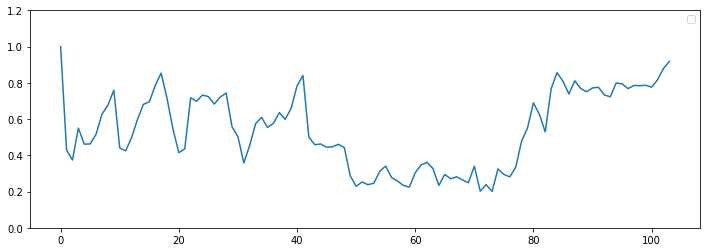

In [177]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

clsCosine = []

for i, vec in enumerate(token_vecs_sum):
    print(i)
    if i == len(tokenized_df[0]) :
      break
    pooler = 1 - cosine(token_vecs_sum[0].detach().cpu().numpy(), vec.detach().cpu().numpy())
    print('[CLS] vs ',tokenized_df[0][i],' :  %f' % pooler)
    clsCosine.append(pooler)
    

plt.figure(figsize = (12,4)) 
plt.plot(clsCosine) 
plt.ylim(0,1.2)

plt.legend();

No handles with labels found to put in legend.


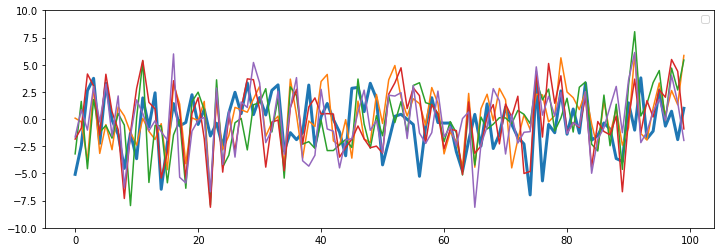

In [178]:
plt.figure(figsize = (12,4)) 
plt.plot(token_vecs_sum[0][:100].detach().cpu().numpy(), linewidth=3)
plt.plot(token_vecs_sum[1][:100].detach().cpu().numpy())
plt.plot(token_vecs_sum[2][:100].detach().cpu().numpy())
plt.plot(token_vecs_sum[3][:100].detach().cpu().numpy())
plt.plot(token_vecs_sum[4][:100].detach().cpu().numpy())

plt.ylim(-10,10)

plt.legend();

In [179]:
import tensorflow as tf
import numpy as np
from IPython.core.display import HTML, display

m = torch.nn.Linear(768, 2, bias=True).to(device)
m.weight.data = model.classifier.weight.to(device)

n = torch.nn.ReLU()
d = torch.nn.Dropout(p=0.1, inplace=False)

In [180]:
result=[]

with torch.no_grad():
  def call_html(i, output, token_str, label):
    # color = str(int(round(output*1000)))

    fake = "<script type='text/javascript'> var span = document.createElement('span'); var newContent = document.createTextNode('"+token_str+" '); span.appendChild(newContent); span.style.color='rgb("+str(output*255)+",0,0)'; document.body.appendChild(span); </script>"
    real = "<script type='text/javascript'> var span = document.createElement('span'); var newContent = document.createTextNode('"+token_str+" '); span.appendChild(newContent); span.style.color='rgb(0,"+str(output*255)+",0)'; document.body.appendChild(span); </script>"

    if label == 0:
      display(HTML(fake))
    else:
      display(HTML(real))
    
  def vis(i, token_str, label):
    output = round(clsCosine[i], 3)
    # output = token_vecs_sum[i]
    # output = output.to(device)
    # output = m(output)
    # result.append(output)
    # result_output = torch.cat(result, dim=0)    
    # output = n(output)
    # output = output.detach().cpu().numpy()
    # output= np.max(output[label])
    call_html(i, output, token_str, label)

    # return result_output

In [181]:
for i, token_str in enumerate(tokenized_df[0]):
  if token_str == "[CLS]" or token_str == "[SEP]"  :
    continue 
    
  histogram = vis(i, token_str, label)